# MITDB ECG Classification Project
December 12, 2019

## Annotations

### Arrhythmia Type List
* N = 'N', 'L', 'R', 'e', 'j'
* SVEB = 'A', 'a', 'J', 'S'
* VEB = 'V', 'E'
* F = 'F'
* Q = '/', 'f'

### Arrhythmia Annotation
* N = Normal beat
* L = Left bundle branch block beat
* R = Right bundle branch block beat
* e = Atrial escape beat
* j = Nodal (junctional) escape beat
* A = Atrial premature beat
* a = Aberrated atrial premature beat
* J = Nodal (junctional) premature beat
* S = Supraventricular premature or ectopic beat (atrial or nodal)
* V = Premature ventricular contraction
* E = Ventricular escape beat
* F = Fusion of ventricular and normal beat
* / = Paced beat
* f = Fusion of paced and normal beat

### The Number of Each Arrhythmia Type
* N = 10001
* L = 8075
* R = 7259
* e = 16
* j = 229
* A = 2546
* a = 150
* J = 83
* S = 2
* V = 7130
* E = 106
* F = 803
* / = 7028
* f = 982

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Keras imports for modeling
from keras.utils import * 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.metrics import *
from keras.callbacks import *

## Functions

In [182]:
# Preprocessing files
def import_hb_csv_and_create_df(csv_file):
    csv_df = pd.read_csv(csv_file)
    csv_df.columns = ['Sample #', 'MLII', 'V5']        
    return csv_df

def import_hb_txt_and_create_df(txt_file):
    txt_df = pd.read_fwf(txt_file)
    return txt_df

def merged_hb_dfs_inner(csv_df, txt_df):
    hb_sample_df = pd.merge(csv_df, txt_df, on='Sample #')
    return hb_sample_df

def merged_hb_dfs_outer(csv_df, txt_df):
    hb_sample_df = pd.merge(csv_df, txt_df, how='outer', on='Sample #')
    return hb_sample_df

# Visualization
def plot_heartbeat(csv_df, txt_df, start_read, end_read):
    MLII = csv_df["MLII"]
    plt.figure(figsize=(20,4)) 
    plt.plot(MLII[start_read : end_read]) 
    plt.show()
    
    
# Upsampling records
def upsample(y, new_len=2200):
    # input (y): vector of readings in 'Readings' column
    # output (y_new): vector of upsampled readings, default size 2200
    x = np.arange(0, len(y), 1)

    stop = (len(y)/360)
    start = 0
    step = (len(y)/360)/len(y)

    t = np.arange(start, stop, step)
    t_new = np.arange(start, stop, stop/new_len)
    
    if (len(t) != len(y)):
        t = t[:-1]
    
    y_new = np.interp(t_new, t, y)
    return y_new


# Normalize records
def find_and_subtract_min_reading(readings_array):
    min_val = round(readings_array.min(), 4)
    readings_array = np.array([(reading-min_val) for i, reading in enumerate(readings_array)])
    return readings_array
    
def find_and_divide_max_reading(readings_array):
    max_val = round(readings_array.max(), 4)
    readings_array = np.array([(reading/max_val) for i, reading in enumerate(readings_array)])
    return readings_array
    
def normalize_readings(readings_array):
    return find_and_divide_max_reading(find_and_subtract_min_reading(readings_array))


# Modeling Results
def y_preds(cnn_fitted_model, X): #X_val, X_test
    return cnn_fitted_model.predict(X)

def y_preds_classes(y_preds): # y_preds comes from previous function
    return y_preds.argmax(axis=-1)

def y_true_classes(y_true): # y_val_set=_y_val
    return y_val.argmax(axis=-1)

# Binary Classification matrix
def plot_confusion_matrix(y_true_classes, y_preds_classes, 
                     xticklabels=['Normal', 'Abnormal'], 
                     yticklabels=['Normal', 'Abnormal'],
                     dpi=100):
   
    conf_matrix = confusion_matrix(y_true_classes, y_preds_classes)
    plt.figure(dpi)
    sns.heatmap(model_v1_a_confusion, cmap=plt.cm.Blues, annot=True, square=True,
               xticklabels=xticklabels,
               yticklabels=yticklabels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix');

## EDA

### `Normal` Record

In [3]:
csv_df_100 = import_hb_csv_and_create_df('mitDB/100.csv')
txt_df_100 = import_hb_txt_and_create_df('mitDB/100annotations.txt')
merged_df_100 = merged_hb_dfs_inner(csv_df_100, txt_df_100)

In [4]:
merged_df_100.head(1)

,Sample #,MLII,V5,Time,Type,Sub,Chan,Num,Aux
0,18,990,1014,0:00.050,+,0,0,0,(N


In [5]:
print(f"Length of sample CSV: {len(csv_df_100)}")
print(f"Length of sample TXT: {len(txt_df_100)}")

Length of sample CSV: 650000
Length of sample TXT: 2274


In [6]:
merged_df_100_2 = merged_hb_dfs_outer(csv_df_100, txt_df_100)

### Visualize Heartbeats

#### [200] Normal / premature Ventricular contraction fluctuation (N/V)

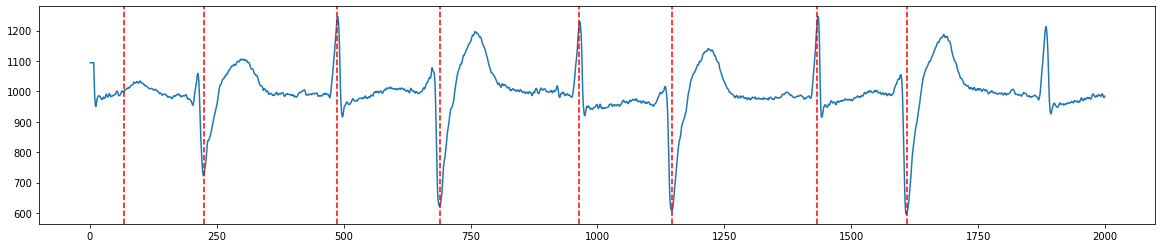

In [84]:
csv_df_200 = import_hb_csv_and_create_df('mitDB/200.csv')
txt_df_200 = import_hb_txt_and_create_df('mitDB/200annotations.txt')
merged_df_200 = merged_hb_dfs_inner(csv_df_200, txt_df_200)

plot_heartbeat(csv_df_200, txt_df_200)

#### [208] Normal / premature Ventricular contraction / Fusion of ventricular and normal beat fluctuation (N/V/F)

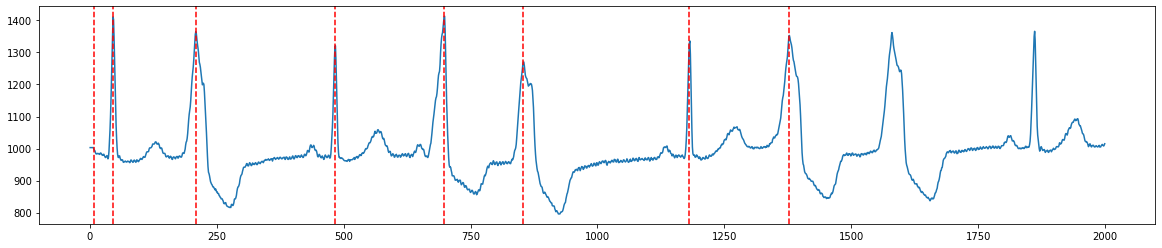

In [85]:
csv_df_208 = import_hb_csv_and_create_df('mitDB/208.csv')
txt_df_208 = import_hb_txt_and_create_df('mitDB/208annotations.txt')
merged_df_208 = merged_hb_dfs_inner(csv_df_208, txt_df_208)

plot_heartbeat(csv_df_208, txt_df_208)

#### [207] Right bundle / premature Ventricular contr / Left bundle / ventricular flutter wave) (R/V/L/!)

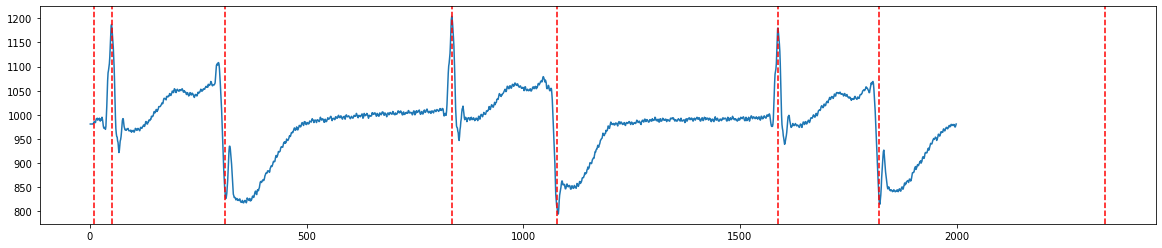

In [86]:
csv_df_207 = import_hb_csv_and_create_df('mitDB/207.csv')
txt_df_207 = import_hb_txt_and_create_df('mitDB/207annotations.txt')
merged_df_207 = merged_hb_dfs_inner(csv_df_207, txt_df_207)

plot_heartbeat(csv_df_207, txt_df_207)

## Preprocessing

### Create dataframe for each file and save as csv/pickle file.

In [40]:
files = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
         111, 112, 113, 114, 115, 116, 117, 118, 119, 121,
         122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 
         209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 
         222, 223, 228, 230, 231, 232, 233, 234]

In [91]:
# iterate through each set of files
for f in files:
    
    # Create separate dfs for each txt & csv file
    csv_df = import_hb_csv_and_create_df(f'mitDB/{f}.csv')
    txt_df = import_hb_txt_and_create_df(f'mitDB/{f}annotations.txt')
    
    # Save beats, types, and readings from associated files as lists
    # Create list with record # to be able to identify record after later concat dfs
    beats = list(txt_df['Sample #'])
    types = list(txt_df['Type'])
    readings = list(csv_df['MLII'])
    record = [f] * len(beats) 
    
    # Create list of readings per beat
    # Save dataframe per record with beats, readings vector and types
    readings_per_beat = []
    prev_a = 0
    
    for a in beats:
        r = readings[prev_a:a+1]
        readings_per_beat.append(r)
        prev_a = a+1
    
    df = pd.DataFrame(list(zip(record, beats, readings_per_beat, types)), 
                      columns=['Record', 'Sample #', 'Readings', 'Type'])
    
    with open(f'record_dfs/{f}_df.pkl', 'wb') as picklefile:
        pickle.dump(df, picklefile)
    
    print(f'{f} Complete!')

100 Complete!
101 Complete!
102 Complete!
103 Complete!
104 Complete!
105 Complete!
106 Complete!
107 Complete!
108 Complete!
109 Complete!
111 Complete!
112 Complete!
113 Complete!
114 Complete!
115 Complete!
116 Complete!
117 Complete!
118 Complete!
119 Complete!
121 Complete!
122 Complete!
123 Complete!
124 Complete!
200 Complete!
201 Complete!
202 Complete!
203 Complete!
205 Complete!
207 Complete!
208 Complete!
209 Complete!
210 Complete!
212 Complete!
213 Complete!
214 Complete!
215 Complete!
217 Complete!
219 Complete!
220 Complete!
221 Complete!
222 Complete!
223 Complete!
228 Complete!
230 Complete!
231 Complete!
232 Complete!
233 Complete!
234 Complete!


### Combine record dataframes into single dataframe for modeling.

In [113]:
# Concantenate dataframes
model_df = pd.DataFrame()

for f in files:
    with open(f'record_dfs/{f}_df.pkl', 'rb') as picklefile:
        df = pickle.load(picklefile)
    model_df = pd.concat([model_df, df], ignore_index=True)
    print(f'{f} Complete')

with open('records_df.pkl', 'wb') as picklefile2:
    pickle.dump(model_df, picklefile2)

100 Complete
101 Complete
102 Complete
103 Complete
104 Complete
105 Complete
106 Complete
107 Complete
108 Complete
109 Complete
111 Complete
112 Complete
113 Complete
114 Complete
115 Complete
116 Complete
117 Complete
118 Complete
119 Complete
121 Complete
122 Complete
123 Complete
124 Complete
200 Complete
201 Complete
202 Complete
203 Complete
205 Complete
207 Complete
208 Complete
209 Complete
210 Complete
212 Complete
213 Complete
214 Complete
215 Complete
217 Complete
219 Complete
220 Complete
221 Complete
222 Complete
223 Complete
228 Complete
230 Complete
231 Complete
232 Complete
233 Complete
234 Complete


### Complete preprocessing steps

In [ ]:
with open('records_df.pkl', 'rb') as picklefile:
    model_df = pickle.load(picklefile)

In [209]:
# Remove paced beats and non-beat annotations
excluded_annots = ['[', ']', 'f', '~', '!', '"', 'x', '|', 'Q', '/', '+']
for annot in excluded_annots:
    model_df = model_df[(model_df['Type'] != annot)]
    
model_df = model_df.reset_index(drop=True)

In [208]:
# Remove 22 potential "incomplete" heartbeats from 2nd sample reading 
model_df['Readings Count'] = model_df['Readings'].copy().apply(lambda x: len(x))
indices_to_remove = list(model_df[(model_df['Readings Count'] < 100) & (model_df['Sample #'] < 200)].reset_index()['index'])
model_df = model_df.drop(model_df.index[indices_to_remove]).reset_index(drop=True)

In [232]:
# Create column to label as normal/not normal for MVP (0 = Normal, 1 = Not Normal)
model_df['Type_Normal'] = model_df['Type'].copy().apply(lambda x: 0 if (x=="N") else 1)

#### Upsample readings to 2200 as highest # of readings is 2114 (ID 97741) & normalize

In [638]:
# Upsample
model_df['Upsampled Readings'] = model_df['Readings'].apply(lambda v: upsample(v))

# vectors are length of 2200 & 2201; reducing to 2200
model_df['Upsampled Readings'] = model_df['Upsampled Readings'].apply(lambda x: x[0:-1] if (len(x) == 2201) else x)

#Normalize data
model_df['Norm Upsampled Readings'] = model_df['Upsampled Readings'].copy().apply(lambda x: normalize_readings(x))

# Reshape data into 2d numpy array of size (2200, 1)
model_df['Norm Upsampled Readings'] = model_df['Norm Upsampled Readings'].apply(lambda x: np.reshape(x, (2200, 1)))

# Reorder columns
model_df = model_df[['Record', 'Sample #', 'Readings Count', 'Upsampled Readings', 'Norm Upsampled Readings', 'Type', 'Type_Normal']]

In [ ]:
with open('model_df_base.pkl' ,'wb') as picklefile:
    pickle.dump(model_df, picklefile)

## Modeling

### Binary

In [103]:
with open('model_df_base.pkl', 'rb') as picklefile:
    model_df = pickle.load(picklefile)
    
model_df_bc = model_df.copy()

#### Split into training/validation/testing data

In [122]:
obs = model_df_bc[['Record', 'Sample #', 'Readings Count', 'Upsampled Readings', 'Norm Upsampled Readings', 'Type']]
label = model_df_bc['Type_Normal']

In [123]:
X, X_test, y, y_test = (train_test_split(obs, label, test_size = .2, random_state = 42))

X_train, X_val, y_train, y_val = (train_test_split(X, y, test_size = .25, random_state = 42))

In [152]:
_X_train = X_train['Norm Upsampled Readings']
_X_val = X_val['Norm Upsampled Readings']
_X_test = X_test['Norm Upsampled Readings']

_X_train = np.concatenate(_X_train.as_matrix(), axis=0).reshape(60858, 2200, 1)
_X_val = np.concatenate(_X_val.as_matrix(), axis=0).reshape(20286, 2200, 1)
_X_test = np.concatenate(_X_test.as_matrix(), axis=0).reshape(20287, 2200, 1)

_y_train = np_utils.to_categorical(y_train)
_y_val = np_utils.to_categorical(y_val)
_y_test = np_utils.to_categorical(y_test)

# Full Training (with validation) and testing
_X = X['Norm Upsampled Readings']
_X = np.concatenate(_X.as_matrix(), axis=0).reshape(81144, 2200, 1)

_y = np_utils.to_categorical(y)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [329]:
#Address class imbalance by adding weights 
# 0    75038
# 1    26393
class_weights = {0: 0.35,
                1: 0.65}

#### Model

In [331]:
input_shape = Input(shape=(2200, 1)) 

mc_bc = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss', save_best_only=False)

conv_e1 = Conv1D(32, 8, activation='relu', padding='same')(input_shape)
pool_e1 = MaxPooling1D(2, padding='same')(conv_e1)

conv_e2 = Conv1D(32, 8, activation='relu', padding='same')(pool_e1)
pool_e2 = MaxPooling1D(2, padding='same')(conv_e2)

conv_e3 = Conv1D(32, 8, activation='relu', padding='same')(pool_e2)
pool_e3 = MaxPooling1D(2, padding='same')(conv_e3)

conv_e4 = Conv1D(32, 8, activation='relu', padding='same')(pool_e3)
pool_e4 = MaxPooling1D(2, padding='same')(conv_e4)

conv_e5 = Conv1D(32, 8, activation='relu', padding='same')(pool_e4)
pool_e5 = MaxPooling1D(2, padding='same')(conv_e5)

flattened_layer = Flatten()(pool_e5)
last_layer = Dense(2, activation='sigmoid')(flattened_layer) 

model_bc_final = Model(input=input_shape, output=last_layer)
model_bc_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

model_bc_final.summary()

model_bc_final_history = model_bc_final.fit(_X, _y, validation_data=(_X_test, _y_test), epochs=25, batch_size=512, verbose=1, class_weight=class_weights, callbacks=[mc_bc])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 2200, 1)           0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 2200, 32)          288       
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 1100, 32)          0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 1100, 32)          8224      
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 550, 32)           0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 550, 32)           8224      
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 275, 32)           0  

#### Results

##### View model history. Plot accuracy and loss.

In [332]:
model_bc_final_history.history 

{'val_loss': [0.18086643142413322,
  0.15503619958176,
  0.1633693174973983,
  0.13144758082281735,
  0.12372076792042282,
  0.15659765515910015,
  0.13072195637100942,
  0.11505194553803239,
  0.10648575444539278,
  0.11164999875423795,
  0.1009813565387165,
  0.10293706631028189,
  0.10119291808666071,
  0.0959841495316178,
  0.10008695112454002,
  0.09696259669577229,
  0.1071863866787544,
  0.09011357347337492,
  0.11354969775288315,
  0.09227335837039316,
  0.09220593932149515,
  0.11640205867847438,
  0.10483703012313533,
  0.08639297281280502,
  0.10236392805365019],
 'val_accuracy': [0.9412184953689575,
  0.9524818658828735,
  0.9465421438217163,
  0.9588652849197388,
  0.9607384204864502,
  0.9482920169830322,
  0.9563513398170471,
  0.9628333449363708,
  0.9652979969978333,
  0.9629072546958923,
  0.9674422144889832,
  0.965445876121521,
  0.9662591814994812,
  0.9693399667739868,
  0.9672696590423584,
  0.9687731266021729,
  0.965224027633667,
  0.970547616481781,
  0.961896

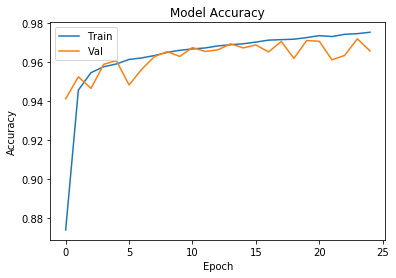

In [333]:
# Plot/summarize history accuracy & loss
plt.plot(model_bc_final_history.history['accuracy'])
plt.plot(model_bc_final_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left');

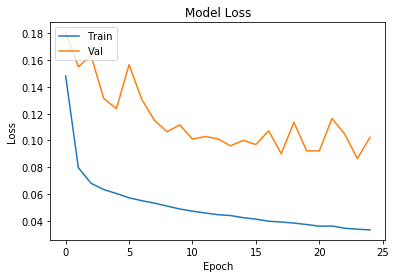

In [335]:
# Plot/summarize history accuracy & loss
plt.plot(model_bc_final_history.history['loss'])
plt.plot(model_bc_final_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left');

##### Plot confusion matrix. Investigate incorrect predictions.

In [348]:
y_preds_bc = model_bc_final.predict(_X_test)
y_preds_classes_bc = y_preds_bc.argmax(axis=-1)
y_true_classes_bc = _y_test.argmax(axis=-1)

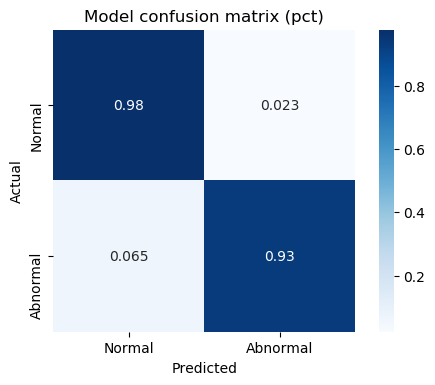

In [376]:
model_bc_final_confusion = confusion_matrix(y_true_classes_bc, y_preds_classes_bc)
model_bc_final_confusion_pct = model_bc_final_confusion.astype('float') / model_bc_final_confusion.sum(axis=1)[:, np.newaxis]
plt.figure(dpi=100)
sns.heatmap(model_bc_final_confusion_pct, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Normal', 'Abnormal'],
           yticklabels=['Normal', 'Abnormal'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model confusion matrix (pct)');

In [352]:
comparison_df_bc = pd.DataFrame(X_test)
comparison_df_bc['y_test'] = y_test
comparison_df_bc['y_pred'] = y_preds_classes_bc

In [353]:
incorrect_detection = comparison_df_bc[comparison_df_bc['y_test'] != comparison_df_bc['y_pred']]['Type'].value_counts()

In [354]:
## Which were incorrectly diagnosed
incorrect_detection

N    347
A     93
R     80
L     52
V     51
j     27
F     23
a      6
J      6
E      3
e      2
S      1
Name: Type, dtype: int64

##### View classification metrics.

In [381]:
accuracy_score(y_true_classes_bc, y_preds_classes_bc)

0.9659387785281215

In [378]:
precision_score(y_true_classes_bc, y_preds_classes_bc)

0.9343300529901589

In [379]:
recall_score(y_true_classes_bc, y_preds_classes_bc)

0.9348608218140504

In [380]:
f1_score(y_true_classes_bc, y_preds_classes_bc)

0.9345953620444866

### Multi-Class

In [238]:
with open('model_df_base.pkl', 'rb') as picklefile:
    model_df = pickle.load(picklefile)

model_df_mc = model_df.copy()

#### Additional Preprocessing

#####  Remove underrepresented beats (<2000)

In [241]:
model_df_mc['Type'].value_counts()

'''
N    75038
L     8073
R     7257
V     7129
A     2546
------
F      802
j      229
a      150
E      106
J       83
e       16
S        2
'''

N    75038
L     8073
R     7257
V     7129
A     2546
F      802
j      229
a      150
E      106
J       83
e       16
S        2
Name: Type, dtype: int64

In [242]:
excluded_annots_mc = ['F', 'j', 'a', 'E', 'J', 'e', 'S']

for annot in excluded_annots_mc:
    model_df_mc = model_df_mc[(model_df_mc['Type'] != annot)]
    
model_df_mc = model_df_mc.reset_index(drop=True)

#### Split into training/validation/testing data

In [245]:
obs_mc = model_df_mc[['Record', 'Sample #', 'Readings Count', 'Upsampled Readings', 'Norm Upsampled Readings']]
label_mc = model_df_mc['Type']

In [274]:
_X_train_mc = X_train_mc['Norm Upsampled Readings']
_X_val_mc = X_val_mc['Norm Upsampled Readings']
_X_test_mc = X_test_mc['Norm Upsampled Readings']

# Training/validation/testing data for CNN
_X_train_mc = np.concatenate(_X_train_mc.as_matrix(), axis=0).reshape(60025, 2200, 1)
_X_val_mc = np.concatenate(_X_val_mc.as_matrix(), axis=0).reshape(20009, 2200, 1)
_X_test_mc = np.concatenate(_X_test_mc.as_matrix(), axis=0).reshape(20009, 2200, 1)

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_mc)
encoded_y_train_mc = encoder.transform(y_train_mc)
encoded_y_val_mc = encoder.transform(y_val_mc)
encoded_y_test_mc = encoder.transform(y_test_mc)

_y_train_mc = np_utils.to_categorical(encoded_y_train_mc)
_y_val_mc = np_utils.to_categorical(encoded_y_val_mc)
_y_test_mc = np_utils.to_categorical(encoded_y_test_mc)

# (Full) Training/testing data for CNN
_X_mc = X_mc['Norm Upsampled Readings']
_X_mc = np.concatenate(_X_mc.as_matrix(), axis=0).reshape(80034, 2200, 1)

encoder_mc = LabelEncoder()
encoder_mc.fit(y_mc)

encoded_y_mc = encoder.transform(y_mc)
encoded_y_test_mc = encoder.transform(y_test_mc)

_y_mc = np_utils.to_categorical(encoded_y_mc)
_y_test_mc = np_utils.to_categorical(encoded_y_test_mc)

'''
0: A
1: L
2: N
3: R
4: V
'''

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [281]:
class_weights_mc = class_weight.compute_class_weight('balanced',
                                                     [0,1,2,3,4],
                                                     encoded_y_train_mc)

In [315]:
class_weights_mc

array([7.88246881, 2.47372759, 0.26645803, 2.76676654, 2.82072368])

#### Model

In [326]:
input_shape = Input(shape=(2200, 1)) 

mcp_mc = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss', save_best_only=False)

conv_e1 = Conv1D(32, 8, activation='relu', padding='same')(input_shape)
pool_e1 = MaxPooling1D(2, padding='same')(conv_e1)

conv_e2 = Conv1D(32, 8, activation='relu', padding='same')(pool_e1)
pool_e2 = MaxPooling1D(2, padding='same')(conv_e2)

conv_e3 = Conv1D(32, 8, activation='relu', padding='same')(pool_e2)
pool_e3 = MaxPooling1D(2, padding='same')(conv_e3)

conv_e4 = Conv1D(32, 8, activation='relu', padding='same')(pool_e3)
pool_e4 = MaxPooling1D(2, padding='same')(conv_e4)

conv_e5 = Conv1D(32, 8, activation='relu', padding='same')(pool_e4)
pool_e5 = MaxPooling1D(2, padding='same')(conv_e5)

flattened_layer = Flatten()(pool_e5)
last_layer = Dense(5, activation='softmax')(flattened_layer) 

model_mc_final = Model(input=input_shape, output=last_layer)
model_mc_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

model_mc_final.summary()

model_mc_final_history = model_mc_final.fit(_X_mc, _y_mc, validation_data=(_X_test_mc, _y_test_mc), epochs=25, batch_size=512, verbose=1, class_weight=class_weights_mc, callbacks=[mcp_mc])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 2200, 1)           0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 2200, 32)          288       
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 1100, 32)          0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 1100, 32)          8224      
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 550, 32)           0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 550, 32)           8224      
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 275, 32)           0  

#### Results

##### View model history. Plot accuracy and loss.

In [1]:
model_mc_final_history.history 

NameError: name 'model_mc_final_history' is not defined

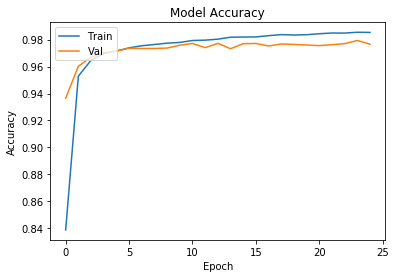

In [356]:
# Plot/summarize history accuracy & loss
plt.plot(model_mc_final_history.history['accuracy'])
plt.plot(model_mc_final_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left');

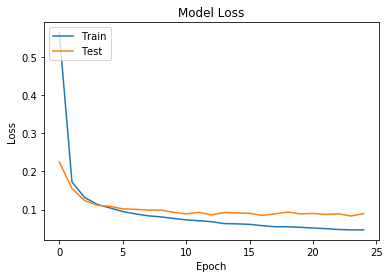

In [358]:
# Plot/summarize history accuracy & loss
plt.plot(model_mc_final_history.history['loss'])
plt.plot(model_mc_final_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left');

##### Plot confusion matrix. Investigate incorrect predictions.

In [359]:
y_preds_mc = y_preds(model_mc_final, _X_test_mc)
y_preds_classes_mc = y_preds_classes(y_preds_mc)
y_true_classes_mc = _y_test_mc.argmax(axis=-1)

In [661]:
conf_matrix_mc = confusion_matrix(y_true_classes_mc, y_preds_classes_mc)
conf_matrix_mc_rate = [ row/sum(row) for row in conf_matrix_mc ]

In [668]:
n = conf_matrix_mc_rate[2]
a = conf_matrix_mc_rate[0]
l = conf_matrix_mc_rate[1]
r = conf_matrix_mc_rate[3]
v = conf_matrix_mc_rate[4]

n = [n[2], n[1], n[0], n[3], n[4]]
a = [a[2], a[0], a[1], a[3], a[4]]
l = [l[2], l[0], l[1], l[3], l[4]]
r = [r[2], r[0], r[1], r[3], r[4]]
v = [v[2], v[0], v[1], v[3], v[4]]

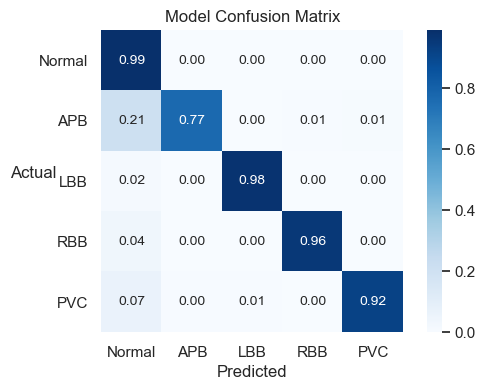

In [679]:
plt.figure(dpi=100)
sns.heatmap([n, a, l, r, v], cmap=plt.cm.Blues, annot=True, square=True, fmt='.2f',
           xticklabels=['Normal', 'APB', 'LBB', 'RBB', 'PVC'],
           yticklabels=['Normal', 'APB', 'LBB', 'RBB', 'PVC'])

plt.yticks(rotation=0)
plt.margins(20,20)
plt.xlabel('Predicted')
plt.ylabel('Actual', rotation=0)
plt.title('Model Confusion Matrix')
plt.savefig('confusion_matrix_mc_pct.png')

In [434]:
# Falsely labeled normal rate – number of abnormal beats predicted to be normal) / (total number of abnormals)
a_fnr = 103/374
l_fnr = 27/1549
r_fnr = 60/1374
v_fnr = 97/1344

print(f"A FNR – {a_fnr}")
print(f"L FNR – {l_fnr}")
print(f"R FNR – {r_fnr}")
print(f"V FNR – {v_fnr}")

A FNR – 0.27540106951871657
L FNR – 0.017430600387346677
R FNR – 0.043668122270742356
V FNR – 0.07217261904761904


##### View classification metrics.

In [400]:
accuracy_score(encoded_y_test_mc, y_preds_classes_mc)

0.9766105252636313